# Import Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy.optimize as sciOp
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
import warnings
from tqdm import trange
from matplotlib import cm

# Initialize Parameters

In [2]:
#### Grid Parameters
TE_array = np.arange(8, 513, 8) #ms units

#### Model parameters
c1 = 0.4
c2 = 0.6
T21 = 45
T22 = 60
T11 = 600
T12 = 1200

true_params = np.array([T11, T12, c1, c2, T21, T22])

param_list = ["T11", "T12", "c1", "c2", "T21", "T22"]

#### Nullpoint Values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#Bound used during NLLS to constrain the upper bound on T2 values
T1_bound = 1500
T2_bound = 300

#Bound used by fminbound
xtol_fixed = 10

#### Process parameters
SNR_fixed = 10**2        #This is the default SNR value
num_iters = 1          #This is how many noisey repitions are used for each TI value
num_starts = 2         #For each iteration, this many starts are used to determine the best parameters - the best answer here for the monoexponential is 2
# rand_seed = 10          #This maintains some consistency between runs
# np.random.seed(rand_seed)

round_params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_params)
pTitleList = ', '.join(x for x in param_list)

details = (f"\nNull Point SNR = {SNR_fixed} \nNum fminbnd Repetitions = {num_iters} :: Num Multistarts (RSS) = {num_starts}" + 
           f"\n{param_list} = {pList}")

print(f'TI1* null point {TI1star}')
print(f'TI2* null point {TI2star}')

TI1* null point 415.88830833596717
TI2* null point 831.7766166719343


# Initialize Functions

### General Functions

In [3]:
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_5p_ravel(T_dat, T11, c1, d2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def S_moX_3p(T_dat, c, T1, T2):
    TE, TI = T_dat
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

def add_noise(data, SNR):
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    return data + noise

def get_func_bounds(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        lower_bound = (-1,-1,0,0)
        upper_bound = (1,1,300,300)
    elif f_name == "S_moX_2p":
        lower_bound = (-1,0)
        upper_bound = (1,300)
    else:
        raise Exception("Not a valid function: " + f_name)
    return lower_bound, upper_bound

def set_p0(lb, ub, func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        f_name = func.__name__
        if f_name.find("moX") > -1:
            p0 = [0,80]
        elif f_name.find("biX") > -1:
            p0 = [0,0,60,80]
        else:
            p0 = true_params
            
    return p0

def convert_fullOutput(output):
    
    if np.size(output)==3 or np.size(output)==5: #in the case of golden search methods
        TIvalue = output[0]
        minErr = output[1]
        numSteps = output[2]
    elif np.size(output)==4: #in the case of fminbound
        TIvalue = output[0]
        minErr = output[1]
        numSteps = output[3]

    outString = ("Opitmal TI value = {:.2f} :: Number of steps = {:.0f}".format(TIvalue,numSteps))

    return outString

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore,axis=0)
    biMat = np.mean(paramStore - true_params ,axis=0)
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, biMat, varMat

### Process Functions

In [4]:
def check_param_order(popt, func):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    
    f_name = func.__name__
    num = 0
    if 'off' in f_name:
        num = -1

    if (popt[-2+num] > popt[-1+num]): #We want by convention to make sure that T21 is <= T22
        for i in range(popt.shape[0]//2):
            p_hold = popt[2*i]
            popt[2*i] = popt[2*i+1]
            popt[2*i+1] = p_hold
    return popt

def estimate_NLLS(func, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(func, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    popt = check_param_order(popt, func)
        
    return popt

def generate_noised_sigs(TI, tdata, SNR = SNR_fixed, params = true_params, iterations = num_iters):
    
    noised_ensemble = np.zeros((iterations,np.size(tdata)))
    for iter in range(iterations):
        true_sig = S_biX_6p(tdata, TI, *params)
        noised_sig = add_noise(true_sig, SNR)
        noised_ensemble[iter,:] = noised_sig
    return noised_ensemble

def multistart_estimate_NLLS(func, tdata, noisey_sig, lb, ub, starts = num_starts):
    best_RSS = np.inf
    best_params = [] 
    for start in range(starts):
        init_p = set_p0(lb, ub, func) #This should almost always be a random initial starting location
        hold_popt = estimate_NLLS(func, tdata, noisey_sig, init_p, lb, ub)
        recreated_curve = func(tdata, *hold_popt)
        recreated_curves_RSS = np.sum((noisey_sig - recreated_curve)**2)

        if recreated_curves_RSS < best_RSS:
            best_RSS = recreated_curves_RSS
            best_params = hold_popt
        
    return best_params, best_RSS

def logical_estimation(TI1st, TI2st, data_np1, data_np2):
    guess_T11 = TI1st/np.log(2)
    guess_T12 = TI2st/np.log(2)

    lb, ub = get_func_bounds(S_moX_2p)

    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np1, lb, ub)
    guess_d2 = best_params[0]
    guess_T22 = best_params[1]

    guess_c2 = guess_d2 / (1 - 2*np.exp(-TI1st/guess_T12))

    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np2, lb, ub)
    guess_d1 = best_params[0]
    guess_T21 = best_params[1]

    guess_c1 = guess_d1 / (1 - 2*np.exp(-TI2st/guess_T11))

    guess_params = [guess_T11, guess_T12, guess_c1, guess_c2, guess_T21, guess_T22]

    return guess_params

### Objective Functions

In [5]:
def calc_RSS_noise(TI, tdata, func, starts = num_starts, SNR_input = SNR_fixed, curve_opt = False):

    data = generate_noised_sigs(TI, tdata, SNR = SNR_input)

    iteration_RSS_values = np.zeros((data.shape[0],1))

    lb, ub = get_func_bounds(func)
    
    for i in range(data.shape[0]):
        noisey_signal = data[i,:]

        recreated_curves = np.zeros((starts,np.size(tdata)))
        recreated_curves_RSS = np.zeros((starts,1))
        recreated_popt = []                     #general to accomodate for different parameter sizes
        for start in range(starts):
            init_p = set_p0(lb, ub, func)
            recreated_popt.append(estimate_NLLS(func, tdata, noisey_signal, init_p, lb, ub))
            recreated_curves[start,:] = func(tdata, *recreated_popt[start])
            recreated_curves_RSS[start] = np.sum((noisey_signal - recreated_curves[start,:])**2)

        iteration_RSS_values[i] = np.min(recreated_curves_RSS)

    if curve_opt:
        return np.mean(iteration_RSS_values), np.squeeze(data)
    return np.mean(iteration_RSS_values)

### Plotting Functions

In [6]:
def get_hist_index(param_label):
    if param_label[-1] == '2':
        row = 1
    else:
        row = 0

    if param_label[:-1] == "T1":
        col = 0
        row = (row+1)%2 #ensures that T11 is on the second row and T12 is on the top row
    elif param_label[:-1] == "c":
        col = 1
    else:
        col = 2

    return row, col

def parameter_histogram(paramStore, true_params, labels, add_title, percentage = False):
    fig, ax = plt.subplots(2, 3, figsize=(12,5.5), tight_layout=True)
    fig.suptitle(add_title + details)

    MSEMat, _, _ = calc_MSE(paramStore, true_params)

    for ii in range(paramStore.shape[1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        if percentage:
            ax[row, col].hist(x=paramStore[:,ii]/true_params[ii]*100, bins=20, color='b', label = labels[ii], alpha = 0.7)
            ax[row, col].set_xlabel('Param Percentage')
            ax[row, col].set_ylabel('Count')
            ax[row, col].axvline(x=100, linewidth=1, label= 'True ' + labels[ii], color='black')
            ax[row, col].axvline(x=np.mean(paramStore[:,ii]/true_params[ii]*100), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")
            
        else:
            ax[row, col].hist(x=paramStore[:,ii] - true_params[ii], bins=20, color='b', label = labels[ii], alpha = 0.7)
            ax[row, col].set_xlabel('Param Difference')
            ax[row, col].set_ylabel('Count')
            ax[row, col].axvline(x=0, linewidth=1, label= 'True ' + labels[ii], color='black')
            ax[row, col].axvline(x=np.mean(paramStore[:,ii]- true_params[ii]), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")
        
        ax[row, col].legend()
        ax[row, col].ticklabel_format(useOffset=False, style='scientific')
        ax[row, col].set_title('True ' + labels[ii] + '=' + "{:.2f}".format(true_params[ii]) + 
                    # '\nVar(' + paramTitle_6p[2*ii] + ') = ' +"{:.2e}".format(varMat[2*ii]) + 
                    # '\nBias(' + paramTitle_6p[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + labels[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()
    return


### Personalized fminbound Function

In [7]:
_status_message = {'success': 'Optimization terminated successfully.',
                   'maxfev': 'Maximum number of function evaluations has '
                              'been exceeded.',
                   'maxiter': 'Maximum number of iterations has been '
                              'exceeded.',
                   'pr_loss': 'Desired error not necessarily achieved due '
                              'to precision loss.',
                   'nan': 'NaN result encountered.',
                   'out_of_bounds': 'The result is outside of the provided '
                                    'bounds.'}

def is_finite_scalar(x):
    """Test whether `x` is either a finite scalar or a finite array scalar.
    """
    return np.size(x) == 1 and np.isfinite(x)

def _endprint(x, flag, fval, maxfun, xtol, disp):
    if flag == 0:
        if disp > 1:
            print("\nOptimization terminated successfully;\n"
                  "The returned value satisfies the termination criteria\n"
                  "(using xtol = ", xtol, ")")
    if flag == 1:
        if disp:
            print("\nMaximum number of function evaluations exceeded --- "
                  "increase maxfun argument.\n")
    if flag == 2:
        if disp:
            print("\n{}".format(_status_message['nan']))
    return

class OptimizeResult(dict):
    """ Represents the optimization result.
    Attributes
    ----------
    x : ndarray
        The solution of the optimization.
    success : bool
        Whether or not the optimizer exited successfully.
    status : int
        Termination status of the optimizer. Its value depends on the
        underlying solver. Refer to `message` for details.
    message : str
        Description of the cause of the termination.
    fun, jac, hess: ndarray
        Values of objective function, its Jacobian and its Hessian (if
        available). The Hessians may be approximations, see the documentation
        of the function in question.
    hess_inv : object
        Inverse of the objective function's Hessian; may be an approximation.
        Not available for all solvers. The type of this attribute may be
        either np.ndarray or scipy.sparse.linalg.LinearOperator.
    nfev, njev, nhev : int
        Number of evaluations of the objective functions and of its
        Jacobian and Hessian.
    nit : int
        Number of iterations performed by the optimizer.
    maxcv : float
        The maximum constraint violation.
    Notes
    -----
    `OptimizeResult` may have additional attributes not listed here depending
    on the specific solver being used. Since this class is essentially a
    subclass of dict with attribute accessors, one can see which
    attributes are available using the `OptimizeResult.keys` method.
    """

    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError as e:
            raise AttributeError(name) from e

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __repr__(self):
        order_keys = ['message', 'success', 'status', 'fun', 'funl', 'x', 'xl',
                      'col_ind', 'nit', 'lower', 'upper', 'eqlin', 'ineqlin']
        # 'slack', 'con' are redundant with residuals
        # 'crossover_nit' is probably not interesting to most users
        omit_keys = {'slack', 'con', 'crossover_nit'}

        def key(item):
            try:
                return order_keys.index(item[0].lower())
            except ValueError:  # item not in list
                return np.inf

        def omit_redundant(items):
            for item in items:
                if item[0] in omit_keys:
                    continue
                yield item

        def item_sorter(d):
            return sorted(omit_redundant(d.items()), key=key)

        if self.keys():
            return sciOp._dict_formatter(self, sorter=item_sorter)
        else:
            return self.__class__.__name__ + "()"

    def __dir__(self):
        return list(self.keys())

def _minimize_scalar_bounded(func, bounds, args=(),
                             xatol=1e-5, maxiter=500, disp=0):
    """
    Options
    -------
    maxiter : int
        Maximum number of iterations to perform.
    disp: int, optional
        If non-zero, print messages.
            0 : no message printing.
            1 : non-convergence notification messages only.
            2 : print a message on convergence too.
            3 : print iteration results.
    xatol : float
        Absolute error in solution `xopt` acceptable for convergence.
    """
    maxfun = maxiter
    # Test bounds are of correct form
    if len(bounds) != 2:
        raise ValueError('bounds must have two elements.')
    x1, x2 = bounds

    if not (is_finite_scalar(x1) and is_finite_scalar(x2)):
        raise ValueError("Optimization bounds must be scalars"
                         " or array scalars.")
    if x1 > x2:
        raise ValueError("The lower bound exceeds the upper bound.")

    flag = 0
    header = ' Func-count     x          f(x)          Procedure'
    step = '       initial'

    sqrt_eps = np.sqrt(2.2e-16)
    golden_mean = 0.5 * (3.0 - np.sqrt(5.0))
    a, b = x1, x2
    fulc = a + golden_mean * (b - a)
    nfc, xf = fulc, fulc
    rat = e = 0.0
    x = xf
    fx, best_curve = func(x, *args) #added best_curve element
    num = 1
    fmin_data = (1, xf, fx)
    fu = np.inf

    ffulc = fnfc = fx
    xm = 0.5 * (a + b)
    tol1 = sqrt_eps * np.abs(xf) + xatol / 3.0
    tol2 = 2.0 * tol1

    if disp > 2:
        track_xvalues = [xf]
        track_yvalues = [fx]
        print(" ")
        print(header)
        print("%5.0f   %12.6g %12.6g %s" % (fmin_data + (step,)))

    while (np.abs(xf - xm) > (tol2 - 0.5 * (b - a))):
        golden = 1
        # Check for parabolic fit
        if np.abs(e) > tol1:
            golden = 0
            r = (xf - nfc) * (fx - ffulc)
            q = (xf - fulc) * (fx - fnfc)
            p = (xf - fulc) * q - (xf - nfc) * r
            q = 2.0 * (q - r)
            if q > 0.0:
                p = -p
            q = np.abs(q)
            r = e
            e = rat

            # Check for acceptability of parabola
            if ((np.abs(p) < np.abs(0.5*q*r)) and (p > q*(a - xf)) and
                    (p < q * (b - xf))):
                rat = (p + 0.0) / q
                x = xf + rat
                step = '       parabolic'

                if ((x - a) < tol2) or ((b - x) < tol2):
                    si = np.sign(xm - xf) + ((xm - xf) == 0)
                    rat = tol1 * si
            else:      # do a golden-section step
                golden = 1

        if golden:  # do a golden-section step
            if xf >= xm:
                e = a - xf
            else:
                e = b - xf
            rat = golden_mean*e
            step = '       golden'

        si = np.sign(rat) + (rat == 0)
        x = xf + si * np.maximum(np.abs(rat), tol1)
        fu, data_curve = func(x, *args) #added best_curve element
        num += 1
        fmin_data = (num, x, fu)
        if disp > 2:
            track_xvalues.append(x)
            track_yvalues.append(fu)
            print("%5.0f   %12.6g %12.6g %s" % (fmin_data + (step,)))

        if fu <= fx:
            if x >= xf:
                a = xf
            else:
                b = xf
            fulc, ffulc = nfc, fnfc
            nfc, fnfc = xf, fx
            xf, fx = x, fu
            best_curve = data_curve
        else:
            if x < xf:
                a = x
            else:
                b = x
            if (fu <= fnfc) or (nfc == xf):
                fulc, ffulc = nfc, fnfc
                nfc, fnfc = x, fu
            elif (fu <= ffulc) or (fulc == xf) or (fulc == nfc):
                fulc, ffulc = x, fu

        xm = 0.5 * (a + b)
        tol1 = sqrt_eps * np.abs(xf) + xatol / 3.0
        tol2 = 2.0 * tol1

        if num >= maxfun:
            flag = 1
            break

    if np.isnan(xf) or np.isnan(fx) or np.isnan(fu):
        flag = 2

    fval = fx
    if disp > 0:
        _endprint(x, flag, fval, maxfun, xatol, disp)

    result = OptimizeResult(fun=fval, status=flag, success=(flag == 0),
                            message={0: 'Solution found.',
                                     1: 'Maximum number of function calls '
                                        'reached.',
                                     2: _status_message['nan']}.get(flag, ''),
                            x=xf, nfev=num, nit=num)

    if disp == 4:
        return result, track_xvalues, track_yvalues, best_curve
    elif disp >2:
        return result, track_xvalues, track_yvalues
    else:
        return result, best_curve

def fminbound(func, x1, x2, args=(), xtol=1e-5, maxfun=500,
              full_output=0, disp=1):
    """Bounded minimization for scalar functions.
    Parameters
    ----------
    func : callable f(x,*args)
        Objective function to be minimized (must accept and return scalars).
    x1, x2 : float or array scalar
        The optimization bounds.
    args : tuple, optional
        Extra arguments passed to function.
    xtol : float, optional
        The convergence tolerance.
    maxfun : int, optional
        Maximum number of function evaluations allowed.
    full_output : bool, optional
        If True, return optional outputs.
    disp : int, optional
        If non-zero, print messages.
            -1: custom - records the monoX curve found at the nullpoint
            0 : no message printing.
            1 : non-convergence notification messages only.
            2 : print a message on convergence too.
            3 : print iteration results.
    Returns
    -------
    xopt : ndarray
        Parameters (over given interval) which minimize the
        objective function.
    fval : number
        The function value at the minimum point.
    ierr : int
        An error flag (0 if converged, 1 if maximum number of
        function calls reached).
    numfunc : int
      The number of function calls made.
    See also
    --------
    minimize_scalar: Interface to minimization algorithms for scalar
        univariate functions. See the 'Bounded' `method` in particular.
    Notes
    -----
    Finds a local minimizer of the scalar function `func` in the
    interval x1 < xopt < x2 using Brent's method. (See `brent`
    for auto-bracketing.)
    Examples
    --------
    `fminbound` finds the minimum of the function in the given range.
    The following examples illustrate the same
    >>> def f(x):
    ...     return x**2
    >>> from scipy import optimize
    >>> minimum = optimize.fminbound(f, -1, 2)
    >>> minimum
    0.0
    >>> minimum = optimize.fminbound(f, 1, 2)
    >>> minimum
    1.0000059608609866
    """
    options = {'xatol': xtol,
               'maxiter': maxfun,
               'disp': disp}

    if disp==4:
        res, track_xvals, track_yvals, best_curve = _minimize_scalar_bounded(func, (x1, x2), args, **options)

        if full_output:
            return [res['x'], res['fun'], res['status'], res['nfev']], track_xvals, track_yvals, best_curve
        else:
            return res['x']

    elif disp>2:
        res, track_xvals, track_yvals = _minimize_scalar_bounded(func, (x1, x2), args, **options)

        if full_output:
            return [res['x'], res['fun'], res['status'], res['nfev']], track_xvals, track_yvals
        else:
            return res['x']
        
    

    else:
        res, best_curve = _minimize_scalar_bounded(func, (x1, x2), args, **options)

        if full_output:
            return [res['x'], res['fun'], res['status'], res['nfev']], best_curve
        else:
            return res['x']

    

# Finding Null Points

### Example Noisy Curve

[6.0e+02 1.2e+03 4.0e-01 6.0e-01 4.5e+01 6.0e+01]
d1 = 0.1466905844967574
d2 = -0.07524584256834684


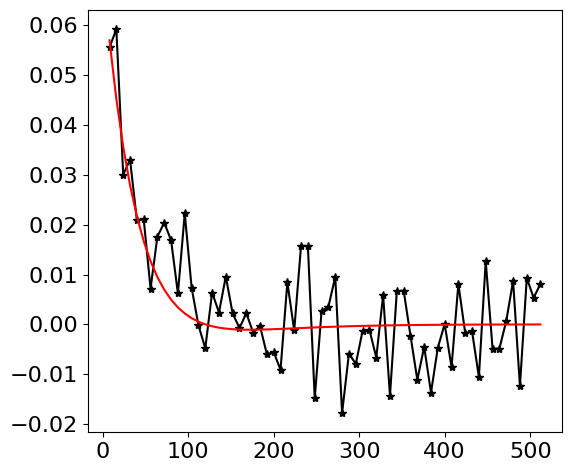

In [30]:
TI_test = 690 

true_sig = S_biX_6p(TE_array,TI_test, *true_params)
data = add_noise(true_sig, SNR_fixed)

fig, ax = plt.subplots(1,1,figsize=(6,5), tight_layout=True)
plt.plot(TE_array, data, color = 'k', marker = '*')
plt.plot(TE_array, true_sig, color = 'r')
print(true_params)
print(f'd1 = {c1*(1-2*np.exp(-TI_test/T11))}')
print(f'd2 = {c2*(1-2*np.exp(-TI_test/T12))}')

### Experiment 1st Null Point

In [8]:
low_TI = 200
high_TI= 600

FMB_moX_RSS, track_xvals, track_yvals, moX_curve_TI1 = fminbound(lambda TI: calc_RSS_noise(TI, TE_array, S_moX_2p, curve_opt = True), low_TI, high_TI, xtol = xtol_fixed, full_output = True, disp = 4)

print(f"RSS at {low_TI} = " + str(calc_RSS_noise(low_TI, TE_array, S_moX_2p)))
print(f"RSS at {high_TI} = " + str(calc_RSS_noise(high_TI, TE_array, S_moX_2p)))
print(f"Scipy Fminbound Technique - Brednt's Method - RSS - SNR = {SNR_fixed}")
print("True Nullpoint 1 = {:.3f}".format(TI1star))
print("True Nullpoint 2 = {:.3f}".format(TI2star))
print("Estimated Nullpoint via RSS of moX results:" + convert_fullOutput(FMB_moX_RSS))
print("     Error = {:.2f} :: Relative Error = {:.2f}%".format(FMB_moX_RSS[0] - TI1star, np.abs(TI1star-FMB_moX_RSS[0])/TI1star*100))


 
 Func-count     x          f(x)          Procedure
    1        352.786   0.00667626        initial
    2        447.214   0.00701845        golden
    3        294.427   0.00731495        golden
    4        380.997   0.00720414        parabolic
    5        330.495   0.00546436        golden
    6        316.718    0.0045989        golden
    7        308.204   0.00598807        golden
    8        320.508   0.00872532        parabolic
    9        313.385   0.00623345        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  10 )
RSS at 200 = 0.005939601048305026
RSS at 600 = 0.005353949855500074
Scipy Fminbound Technique - Brednt's Method - RSS - SNR = 100
True Nullpoint 1 = 415.888
True Nullpoint 2 = 831.777
Estimated Nullpoint via RSS of moX results:Opitmal TI value = 316.72 :: Number of steps = 9
     Error = -99.17 :: Relative Error = 23.85%


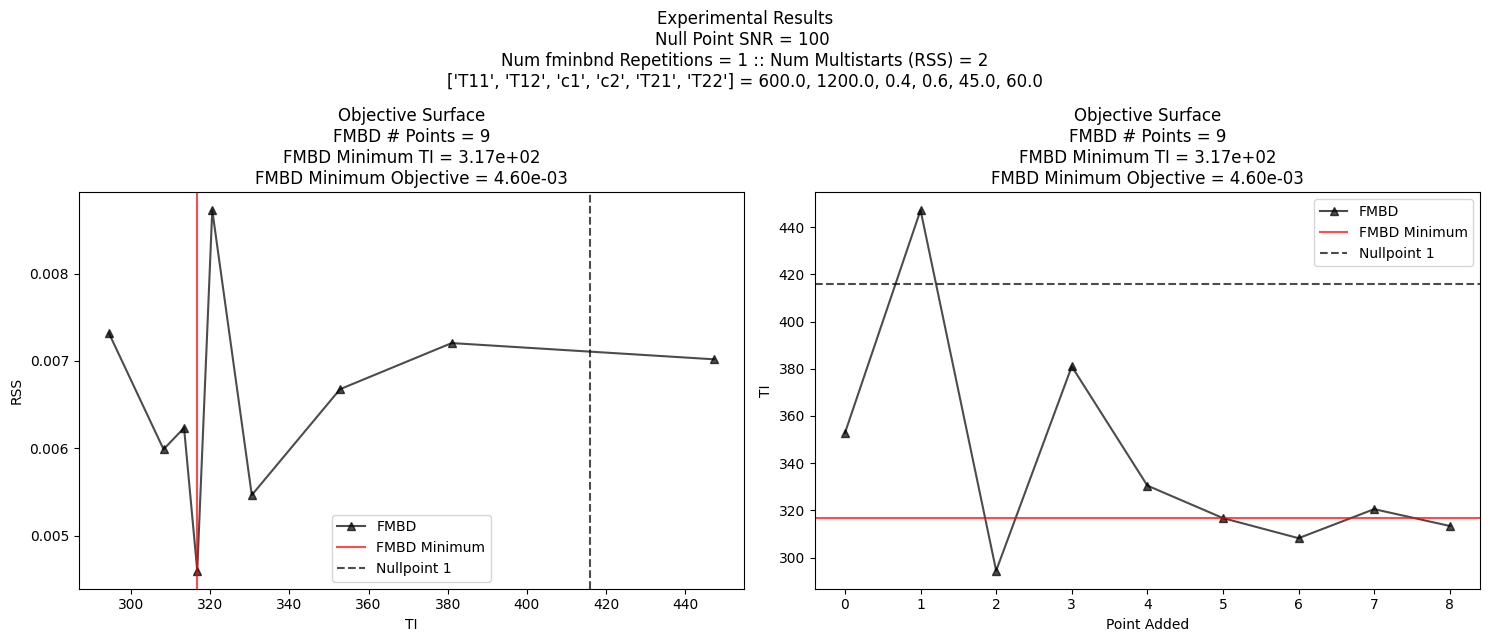

In [9]:
TI_fmbd_sorted_index = np.argsort(track_xvals)
TI_fmbd_sorted = np.take_along_axis(np.array(track_xvals), TI_fmbd_sorted_index, axis=0)
obj_fmbd_sorted = np.take_along_axis(np.array(track_yvals), TI_fmbd_sorted_index, axis=0)

fig, ax = plt.subplots(1,2,figsize=(15,6.5), tight_layout=True)

fig.suptitle('Experimental Results' + details)

ax[0].plot(TI_fmbd_sorted, obj_fmbd_sorted, label = 'FMBD', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=FMB_moX_RSS[0], label = 'FMBD Minimum', alpha = 0.7, color ='r', ls = '-')
ax[0].axvline(x=TI1star, label = 'Nullpoint 1', alpha = 0.7, color ='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('RSS')
ax[0].set_title('Objective Surface' + 
                '\nFMBD # Points = ' + str(FMB_moX_RSS[3]) +
                '\nFMBD Minimum TI = {:.2e}'.format(FMB_moX_RSS[0]) + 
                '\nFMBD Minimum Objective = {:.2e}'.format(FMB_moX_RSS[1]))
ax[0].legend()

ax[1].plot(track_xvals, label = 'FMBD', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axhline(y=FMB_moX_RSS[0], label = 'FMBD Minimum', alpha = 0.7, color ='r', ls = '-')
ax[1].axhline(y=TI1star, label = 'Nullpoint 1', alpha = 0.7, color ='k', ls = '--')
ax[1].set_xlabel('Point Added')
ax[1].set_ylabel('TI')
ax[1].set_title('Objective Surface' + 
                '\nFMBD # Points = ' + str(FMB_moX_RSS[3]) +
                '\nFMBD Minimum TI = {:.2e}'.format(FMB_moX_RSS[0]) + 
                '\nFMBD Minimum Objective = {:.2e}'.format(FMB_moX_RSS[1]))
ax[1].legend()

### Experiment 2nd Null Point

In [10]:
low_TI = 600
high_TI= 1500

FMB_moX_RSS_np2, track_xvals_np2, track_yvals_np2, moX_curve_TI2 = fminbound(lambda TI: calc_RSS_noise(TI, TE_array, S_moX_2p, curve_opt = True), low_TI, high_TI, xtol = xtol_fixed, full_output = True, disp = 4)

print(f"RSS at {low_TI} = " + str(calc_RSS_noise(low_TI, TE_array, S_moX_2p)))
print(f"RSS at {high_TI} = " + str(calc_RSS_noise(high_TI, TE_array, S_moX_2p)))
print(f"Scipy Fminbound Technique - Brednt's Method - RSS - SNR = {SNR_fixed}")
print("True Nullpoint 1 = {:.3f}".format(TI1star))
print("True Nullpoint 2 = {:.3f}".format(TI2star))
print("Estimated Nullpoint via RSS of moX results:" + convert_fullOutput(FMB_moX_RSS_np2))
print("     Error = {:.2f} :: Relative Error = {:.2f}%".format(FMB_moX_RSS_np2[0] - TI2star,np.abs(TI2star-FMB_moX_RSS_np2[0])/TI2star*100))


 
 Func-count     x          f(x)          Procedure
    1        943.769   0.00605698        initial
    2        1156.23   0.00553173        golden
    3        1287.54   0.00635609        golden
    4        1098.56   0.00513967        parabolic
    5        1070.64   0.00588275        parabolic
    6        1118.69   0.00493888        parabolic
    7        1122.02   0.00641516        parabolic
    8        1115.35   0.00737715        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  10 )
RSS at 600 = 0.005607690582216699
RSS at 1500 = 0.006217182141963835
Scipy Fminbound Technique - Brednt's Method - RSS - SNR = 100
True Nullpoint 1 = 415.888
True Nullpoint 2 = 831.777
Estimated Nullpoint via RSS of moX results:Opitmal TI value = 1118.69 :: Number of steps = 8
     Error = 286.91 :: Relative Error = 34.49%


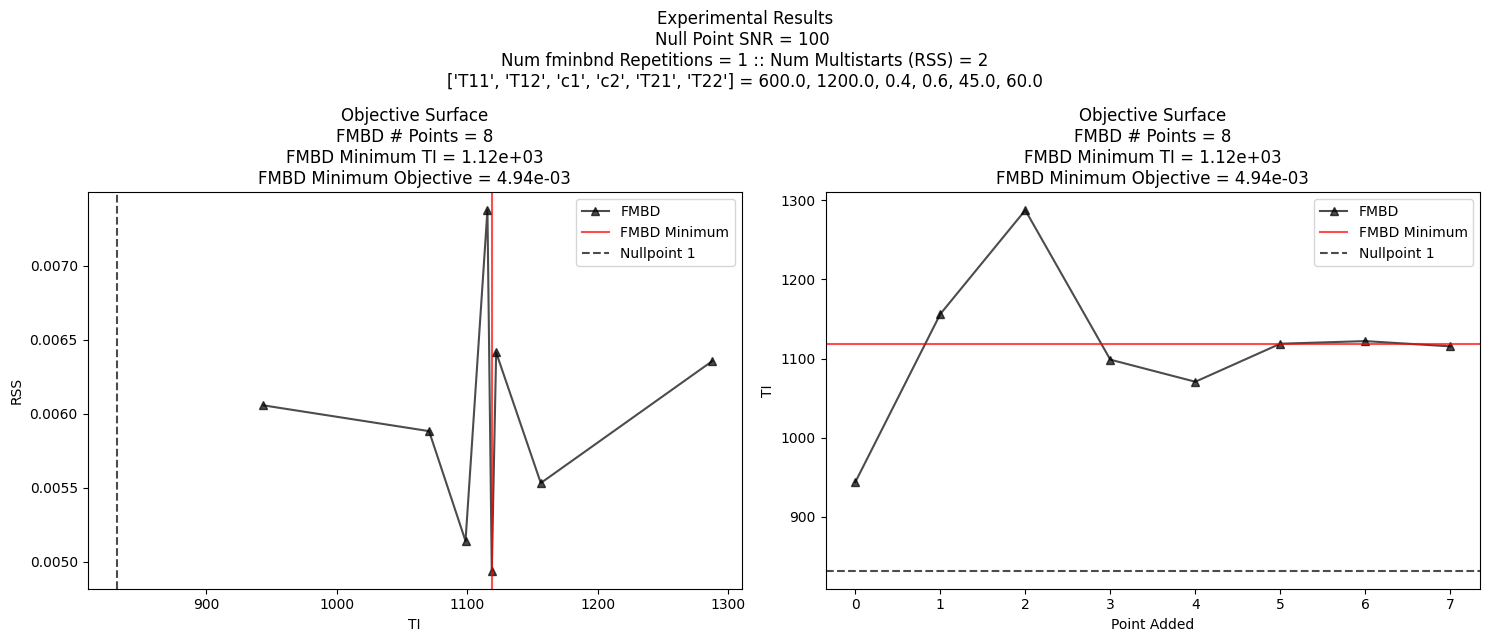

In [11]:
TI_fmbd_sorted_index_np2 = np.argsort(track_xvals_np2)
TI_fmbd_sorted_np2 = np.take_along_axis(np.array(track_xvals_np2), TI_fmbd_sorted_index_np2, axis=0)
obj_fmbd_sorted_np2 = np.take_along_axis(np.array(track_yvals_np2), TI_fmbd_sorted_index_np2, axis=0)

fig, ax = plt.subplots(1,2,figsize=(15,6.5), tight_layout=True)

fig.suptitle('Experimental Results' + details)

ax[0].plot(TI_fmbd_sorted_np2, obj_fmbd_sorted_np2, label = 'FMBD', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[0].axvline(x=FMB_moX_RSS_np2[0], label = 'FMBD Minimum', alpha = 0.7, color ='r', ls = '-')
ax[0].axvline(x=TI2star, label = 'Nullpoint 1', alpha = 0.7, color ='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('RSS')
ax[0].set_title('Objective Surface' + 
                '\nFMBD # Points = ' + str(FMB_moX_RSS_np2[3]) +
                '\nFMBD Minimum TI = {:.2e}'.format(FMB_moX_RSS_np2[0]) + 
                '\nFMBD Minimum Objective = {:.2e}'.format(FMB_moX_RSS_np2[1]))
ax[0].legend()

ax[1].plot(track_xvals_np2, label = 'FMBD', alpha = 0.7, color ='k', ls = '-', marker = '^')
ax[1].axhline(y=FMB_moX_RSS_np2[0], label = 'FMBD Minimum', alpha = 0.7, color ='r', ls = '-')
ax[1].axhline(y=TI2star, label = 'Nullpoint 1', alpha = 0.7, color ='k', ls = '--')
ax[1].set_xlabel('Point Added')
ax[1].set_ylabel('TI')
ax[1].set_title('Objective Surface' + 
                '\nFMBD # Points = ' + str(FMB_moX_RSS_np2[3]) +
                '\nFMBD Minimum TI = {:.2e}'.format(FMB_moX_RSS_np2[0]) + 
                '\nFMBD Minimum Objective = {:.2e}'.format(FMB_moX_RSS_np2[1]))
ax[1].legend()

### Compare to Actual Surface

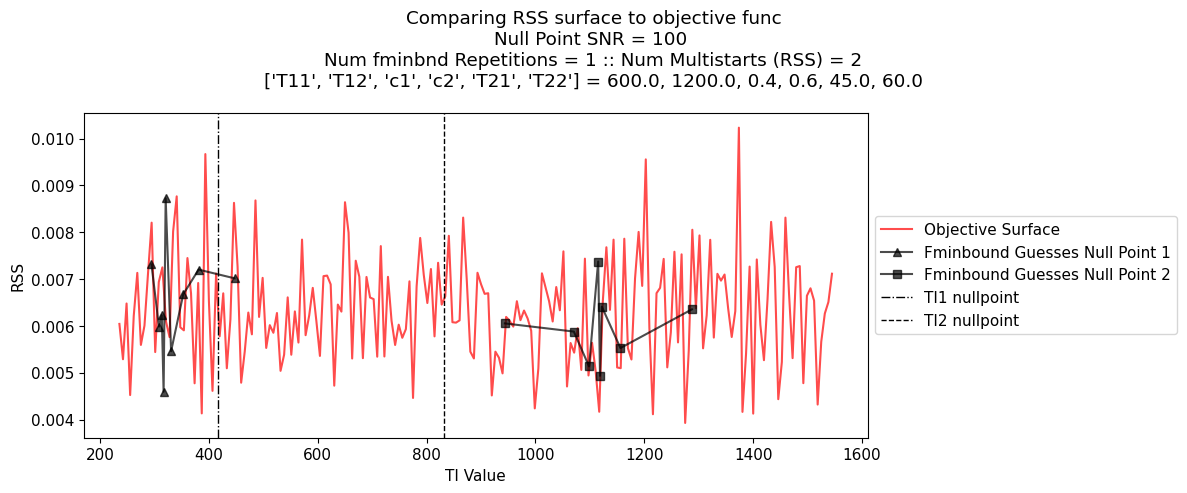

In [12]:
low_TI_range = np.round(TI_fmbd_sorted[0]*0.8 ,1)
high_TI_range = np.round(TI_fmbd_sorted_np2[-1]*1.2 ,1)

TI_range_steps = 200

TI_range = np.linspace(low_TI_range, high_TI_range, TI_range_steps)

RSS_range = [calc_RSS_noise(TI_hold, TE_array, S_moX_2p, starts = 10) for TI_hold in TI_range]

plt.rc('font', size = 11)
fig = plt.figure(figsize=(12,5), tight_layout=True)
fig.suptitle('Comparing RSS surface to objective func' + details)
plt.plot(TI_range, RSS_range, label= 'Objective Surface', alpha = 0.7, color = 'r')
plt.plot(TI_fmbd_sorted, obj_fmbd_sorted, label= 'Fminbound Guesses Null Point 1', alpha = 0.7, color = 'k', marker = '^')
plt.plot(TI_fmbd_sorted_np2, obj_fmbd_sorted_np2, label= 'Fminbound Guesses Null Point 2', alpha = 0.7, color = 'k', marker = 's')
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '-.')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
# plt.axvline(x=FMB_moX_RSS[0], linewidth=1, label= 'Estimated TI1 nullpoint', color='b', ls = '--', alpha = 0.2)
# plt.axvline(x=FMB_moX_RSS_np2[0], linewidth=1, label= 'Estimated TI2 nullpoint', color='b', ls = '-.', alpha = 0.2)
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

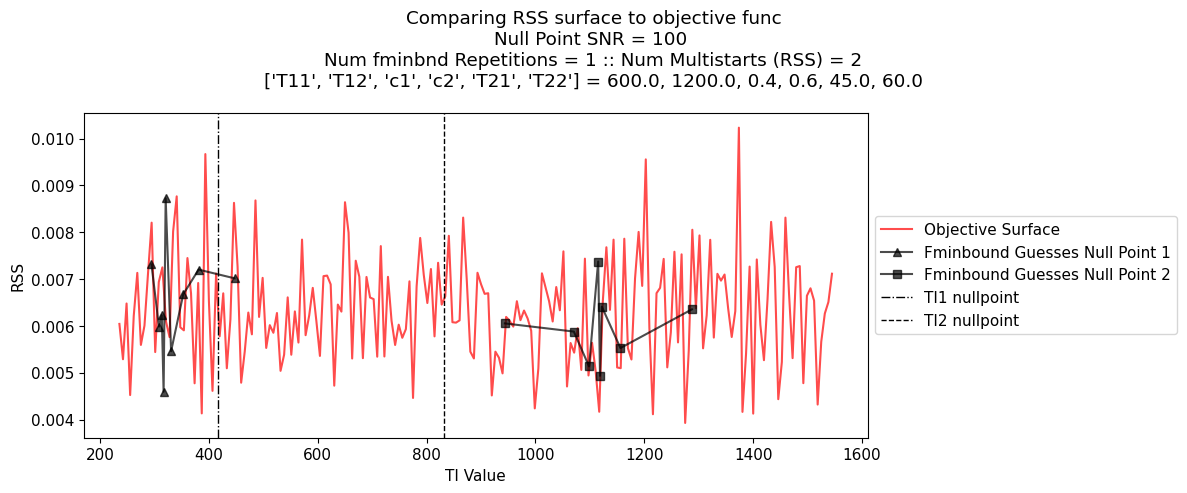

In [13]:
low_TI_range = np.round(TI_fmbd_sorted[0]*0.8 ,1)
high_TI_range = np.round(TI_fmbd_sorted_np2[-1]*1.2 ,1)

mid_TI = int((TI1star+TI2star)/2)
low_TI_array = np.linspace(100, mid_TI, 50)
high_TI_array = np.linspace(mid_TI+1, 1200, 50)

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_low = R0_coeff_TI1*(low_TI_array - TI1star)**2

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theoretical_high = R0_coeff_TI2*(low_TI_array - TI2star)**2

RSS_TI_values = np.concatenate((low_TI_array, high_TI_array))
RSS_theoretical_values = np.concatenate((RSS_theoretical_low, RSS_theoretical_high))

plt.rc('font', size = 11)
fig = plt.figure(figsize=(12,5), tight_layout=True)
fig.suptitle('Comparing RSS surface to objective func' + details)
plt.plot(TI_range, RSS_range, label= 'Objective Surface', alpha = 0.7, color = 'r')
plt.plot(TI_fmbd_sorted, obj_fmbd_sorted, label= 'Fminbound Guesses Null Point 1', alpha = 0.7, color = 'k', marker = '^')
plt.plot(TI_fmbd_sorted_np2, obj_fmbd_sorted_np2, label= 'Fminbound Guesses Null Point 2', alpha = 0.7, color = 'k', marker = 's')
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '-.')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
# plt.axvline(x=FMB_moX_RSS[0], linewidth=1, label= 'Estimated TI1 nullpoint', color='b', ls = '--', alpha = 0.2)
# plt.axvline(x=FMB_moX_RSS_np2[0], linewidth=1, label= 'Estimated TI2 nullpoint', color='b', ls = '-.', alpha = 0.2)
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

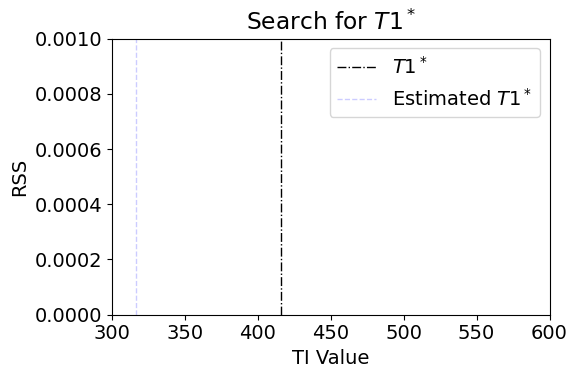

In [14]:
low_TI_range = np.round(TI_fmbd_sorted[0]*0.8 ,1)
high_TI_range = np.round(TI_fmbd_sorted_np2[-1]*1.2 ,1)

mid_TI = int((TI1star+TI2star)/2)
low_TI_array = np.linspace(100, mid_TI, 50)
high_TI_array = np.linspace(mid_TI+1, 1200, 50)

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_low = R0_coeff_TI1*(low_TI_array - TI1star)**2

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theoretical_high = R0_coeff_TI2*(low_TI_array - TI2star)**2

RSS_TI_values = np.concatenate((low_TI_array, high_TI_array))
RSS_theoretical_values = np.concatenate((RSS_theoretical_low, RSS_theoretical_high))

plt.rc('font', size = 14)
fig = plt.figure(figsize=(6,4), tight_layout=True)
plt.title('Search for ' + r'$T1^*$')
plt.plot(TI_range, RSS_range, alpha = 0.7, color = 'r')
plt.plot(TI_fmbd_sorted, obj_fmbd_sorted, alpha = 0.7, color = 'k', marker = '^')
# plt.plot(TI_fmbd_sorted_np2, obj_fmbd_sorted_np2, alpha = 0.7, color = 'k', marker = 's')
plt.axvline(x=TI1star, linewidth=1, label= r'$T1^*$', color='k', ls = '-.')
# plt.axvline(x=TI2star, linewidth=1, label= r'$T2^*$', color='k', ls = '--')
plt.xlim([300, 600])
plt.ylim([0,0.001])
plt.axvline(x=FMB_moX_RSS[0], linewidth=1, label= r'Estimated $T1^*$', color='b', ls = '--', alpha = 0.2)
# plt.axvline(x=FMB_moX_RSS_np2[0], linewidth=1, label= r'Estimated $T2^*$', color='b', ls = '-.', alpha = 0.8)
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.legend()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

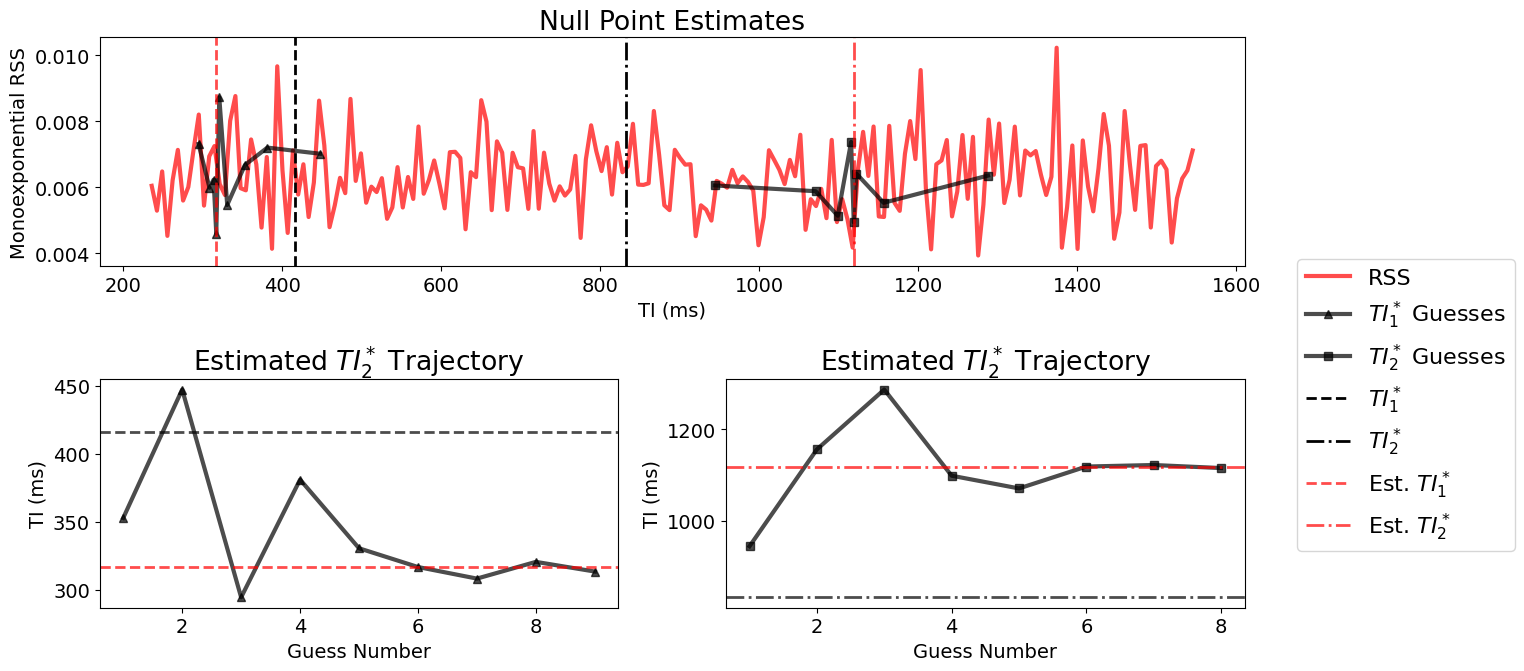

In [15]:
fig = plt.figure(figsize=(13,7), tight_layout=True)

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

plt.rc('font', size = 16)
# fig.suptitle('Comparing RSS surface to objective func' + details)

ax1.plot(TI_range, RSS_range, label= 'RSS', alpha = 0.7, color = 'r', linewidth=3)
ax1.plot(TI_fmbd_sorted, obj_fmbd_sorted, label= r'$TI_1^*$ Guesses', alpha = 0.7, color = 'k', marker = '^', linewidth=3)
ax1.plot(TI_fmbd_sorted_np2, obj_fmbd_sorted_np2, label= r'$TI_2^*$ Guesses', alpha = 0.7, color = 'k', marker = 's', linewidth=3)
ax1.axvline(x=TI1star, linewidth=2, label= r'$TI_1^*$', color='k', ls = '--')
ax1.axvline(x=TI2star, linewidth=2, label= r'$TI_2^*$', color='k', ls = '-.')
ax1.axvline(x=FMB_moX_RSS[0], linewidth=2, label= r'Est. $TI_1^*$', color='r', ls = '--', alpha = 0.7)
ax1.axvline(x=FMB_moX_RSS_np2[0], linewidth=2, label= r'Est. $TI_2^*$', color='r', ls = '-.', alpha = 0.7)
ax1.set_xlabel('TI (ms)')
ax1.set_ylabel('Monoexponential RSS')
ax1.set_title('Null Point Estimates')

handler, labeler = ax1.get_legend_handles_labels()

ax2.plot(np.arange(1, np.size(track_xvals) + 1, 1), track_xvals, label = 'Guesses', alpha = 0.7, color ='k', ls = '-', marker = '^', linewidth=3)
ax2.axhline(y=FMB_moX_RSS[0], label = r'Est. $TI_1^*$', alpha = 0.7, color ='r', ls = '--', linewidth=2)
ax2.axhline(y=TI1star, label = r'$TI_1^*$', alpha = 0.7, color ='k', ls = '--', linewidth=2)
ax2.set_xlabel('Guess Number')
ax2.set_ylabel('TI (ms)')
ax2.set_title(r'Estimated $TI_2^*$ Trajectory')

ax3.plot(np.arange(1, np.size(track_xvals_np2) + 1, 1), track_xvals_np2, label = 'Guesses', alpha = 0.7, color ='k', ls = '-', marker = 's', linewidth=3)
ax3.axhline(y=FMB_moX_RSS_np2[0], label = r'Est. $TI_2^*$', alpha = 0.7, color ='r', ls = '-.', linewidth=2)
ax3.axhline(y=TI2star, label = r'$TI_2^*$', alpha = 0.7, color ='k', ls = '-.', linewidth=2)
ax3.set_xlabel('Guess Number')
ax3.set_ylabel('TI (ms)')
ax3.set_title(r'Estimated $TI_2^*$ Trajectory')

fig.legend(handler, labeler, loc='center left', bbox_to_anchor=(1, 0.4))

plt.show()

### Strategic Fitting

In [16]:
guess_params = logical_estimation(FMB_moX_RSS[0], FMB_moX_RSS_np2[0], moX_curve_TI1, moX_curve_TI2)

for i in range(np.size(guess_params)):
    print(f"True value for {param_list[i]} = {true_params[i]} :: estimated value for {param_list[i]} = {guess_params[i] : 0.1f}")
    print(f"Error for {param_list[i]} = {guess_params[i] - true_params[i] : 0.3f} :: relative error for {param_list[i]} = {(guess_params[i] - true_params[i])/true_params[i]: 0.3f}\n")

True value for T11 = 600.0 :: estimated value for T11 =  456.9
Error for T11 = -143.072 :: relative error for T11 = -0.238

True value for T12 = 1200.0 :: estimated value for T12 =  1613.9
Error for T12 =  413.925 :: relative error for T12 =  0.345

True value for c1 = 0.4 :: estimated value for c1 =  0.5
Error for c1 =  0.087 :: relative error for c1 =  0.218

True value for c2 = 0.6 :: estimated value for c2 =  0.6
Error for c2 = -0.012 :: relative error for c2 = -0.021

True value for T21 = 45.0 :: estimated value for T21 =  48.8
Error for T21 =  3.837 :: relative error for T21 =  0.085

True value for T22 = 60.0 :: estimated value for T22 =  59.6
Error for T22 = -0.422 :: relative error for T22 = -0.007



# Estimate Parameters

### Monte Carlo of Monoexponential Algorithm

In [17]:
MC_iterations = 1000

all_guess_params = np.zeros((MC_iterations, 6))
all_guess_steps = np.zeros((MC_iterations, 3))
all_nullpoints = np.zeros((MC_iterations, 2))

for i in trange(MC_iterations):
    low_TI_np1 = 200
    high_TI_np1= 600
    FMB_moX_RSS, moX_TI1 = fminbound(lambda TI: calc_RSS_noise(TI, TE_array, S_moX_2p, curve_opt = True), low_TI_np1, high_TI_np1, xtol = xtol_fixed, full_output = True, disp = 0)

    low_TI_np2 = 600
    high_TI_np2 = 1200
    FMB_moX_RSS_np2, moX_TI2 = fminbound(lambda TI: calc_RSS_noise(TI, TE_array, S_moX_2p, curve_opt = True), low_TI_np2, high_TI_np2, xtol = xtol_fixed, full_output = True, disp = 0)

    guess_params = logical_estimation(FMB_moX_RSS[0], FMB_moX_RSS_np2[0], moX_TI1, moX_TI2)

    all_guess_params[i,:] = guess_params
    all_guess_steps[i,:] = [FMB_moX_RSS[3], FMB_moX_RSS_np2[3], FMB_moX_RSS[3] + FMB_moX_RSS_np2[3]]
    all_nullpoints[i,:] = [FMB_moX_RSS[0], FMB_moX_RSS_np2[0]]

  3%|▎         | 26/1000 [00:12<07:46,  2.09it/s]


KeyboardInterrupt: 

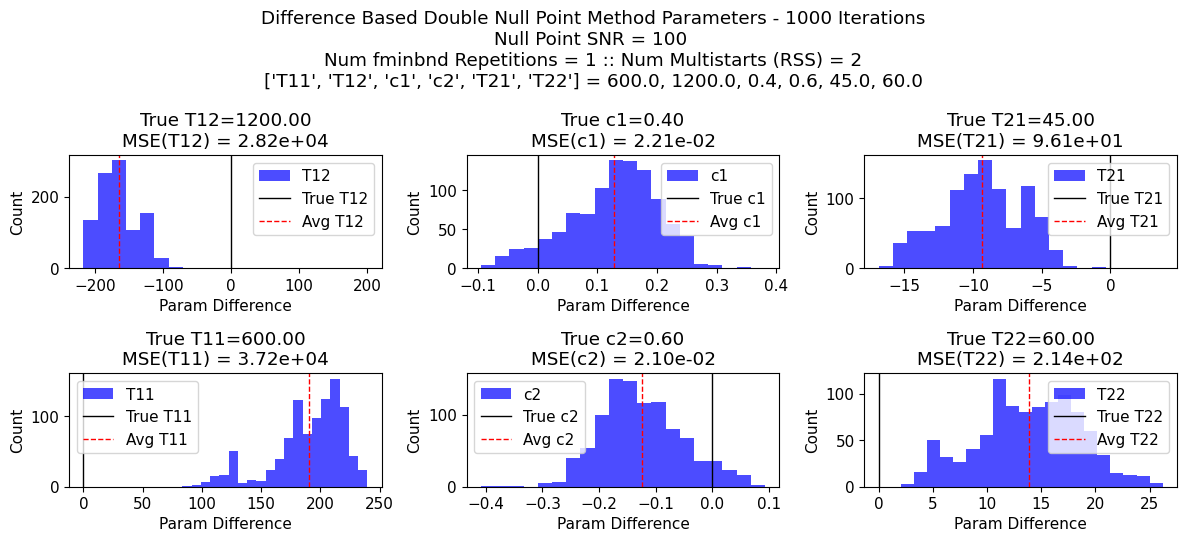

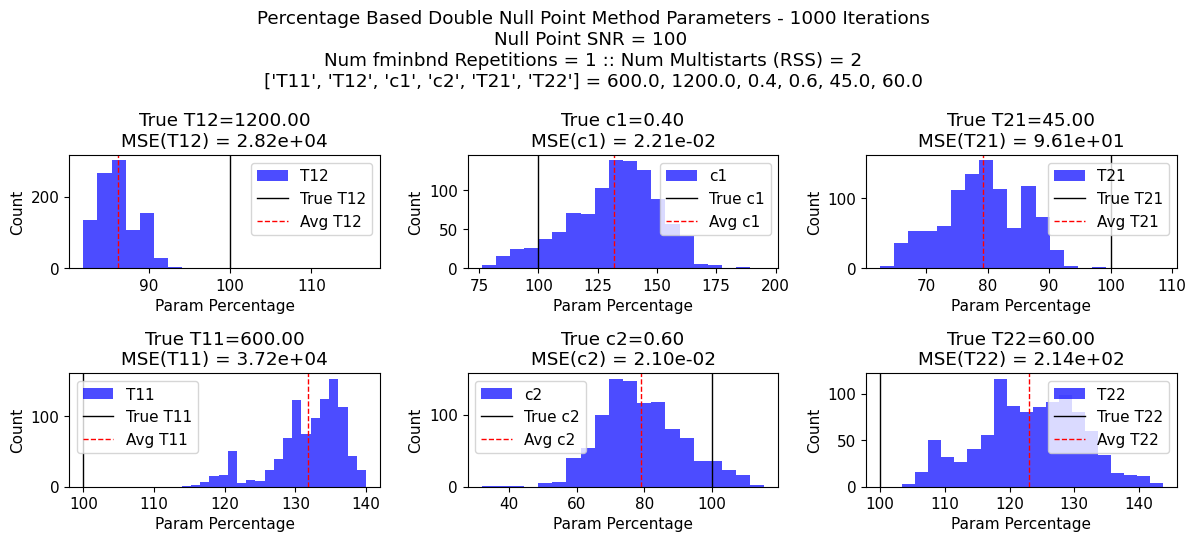

In [ ]:
##### Plots Conventional Results
title_hold = f"Difference Based Double Null Point Method Parameters - {MC_iterations} Iterations"
plt.rc('font', size = 11)
parameter_histogram(all_guess_params, true_params, param_list, title_hold)

title_hold = f"Percentage Based Double Null Point Method Parameters - {MC_iterations} Iterations"
plt.rc('font', size = 11)
parameter_histogram(all_guess_params, true_params, param_list, title_hold, percentage = True)

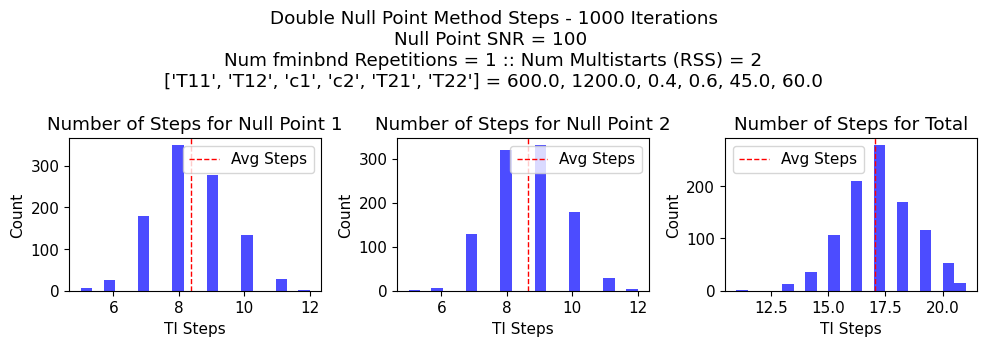

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,3.5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle(f"Double Null Point Method Steps - {MC_iterations} Iterations" + details)

step_labels = ['Null Point 1', 'Null Point 2', 'Total']

for ii in range(all_guess_steps.shape[1]):

    #Construct a nice figure of each of the two 
    ax[ii].hist(x=all_guess_steps[:,ii], bins=20, color='b', alpha = 0.7)
    ax[ii].set_xlabel('TI Steps')
    ax[ii].set_ylabel('Count')
    ax[ii].axvline(x=np.mean(all_guess_steps[:,ii]), linewidth=1, label= 'Avg Steps', color='red', ls = "--")
    ax[ii].legend()
    ax[ii].set_title("Number of Steps for " + step_labels[ii])
plt.show()

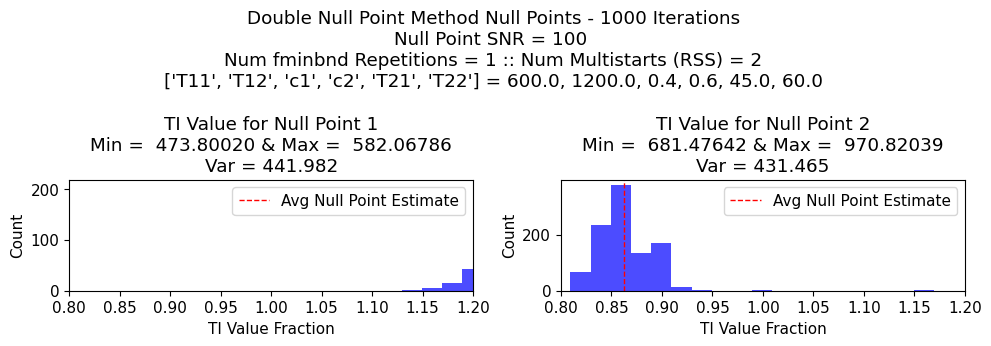

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3.5), tight_layout=True)
plt.rc('font', size = 11)
fig.suptitle(f"Double Null Point Method Null Points - {MC_iterations} Iterations" + details)

step_labels = ['Null Point 1', 'Null Point 2']
true_nullpoints = [TI1star, TI2star]

binwidth = 0.02

for ii in range(all_nullpoints.shape[1]):
    data = all_nullpoints[:,ii]/true_nullpoints[ii]
    #Construct a nice figure of each of the two 
    ax[ii].hist(x=all_nullpoints[:,ii]/true_nullpoints[ii], bins=np.arange(min(data)-binwidth/2, max(data) + binwidth/2, binwidth), color='b', alpha = 0.7)
    ax[ii].set_xlim([0.8,1.2])
    ax[ii].set_xlabel('TI Value Fraction')
    ax[ii].set_ylabel('Count')
    ax[ii].axvline(x=np.mean(all_nullpoints[:,ii]/true_nullpoints[ii]), linewidth=1, label= 'Avg Null Point Estimate', color='red', ls = "--")
    ax[ii].legend()
    ax[ii].ticklabel_format(useOffset=False)#, style='plain')
    ax[ii].set_title("TI Value for " + step_labels[ii] + f'\nMin = {np.min(all_nullpoints[:,ii]): 0.5f} & Max = {np.max(all_nullpoints[:,ii]): 0.5f}\nVar = {np.var(all_nullpoints[:,ii]):0.3f}')
plt.show()

# display(all_nullpoints[:,1]/true_nullpoints[1])

### Conventional Method

In [ ]:
desired_TI_low = 100
desired_TI_high = 2500

TI_numpoints = 15

TI_array_conven = np.logspace(np.log10(desired_TI_low), np.log10(desired_TI_high), 15)

print(f'There are {np.size(TI_array_conven)} points in the conventional method')
print(f'On average, there are {np.mean(all_guess_steps[:,-1])} points in the null point method')

SNR_conventional = SNR_fixed * ((np.mean(all_guess_steps[:,-1]))/np.size(TI_array_conven))**(1/2)
print(f'SNR of null point method = {SNR_fixed} :: SNR of conventional method = {SNR_conventional}')

There are 15 points in the conventional method
On average, there are 17.033 points in the null point method
SNR of null point method = 100 :: SNR of conventional method = 106.56140639712548


In [ ]:
lb_default = [0,0,0,0,0,0]
ub_default = [T1_bound, T1_bound, 1, 1, T2_bound, T2_bound]

# SNR_conventional = SNR_fixed
# np.random.seed(3)
all_conven_params = np.zeros((MC_iterations, 6))

for iter in trange(MC_iterations):
    # np.random.seed(iter)
    mTE_c, mTI_c = np.meshgrid(TE_array, TI_array_conven)
    mS_c = S_biX_6p(mTE_c,mTI_c,*true_params)
    mS_noised_c = add_noise(mS_c, SNR_conventional)

    vecT_c = np.vstack((mTE_c.ravel(), mTI_c.ravel())) #flattens the data points
    vecS_c = mS_noised_c.ravel()

    #### Estimate parameters without any parameters known
    popt_6p_conven, RSS_hold = multistart_estimate_NLLS(S_biX_6p_ravel, vecT_c, vecS_c, lb_default, ub_default)
    all_conven_params[iter, :] = popt_6p_conven

 84%|████████▍ | 845/1000 [02:34<00:28,  5.48it/s]


KeyboardInterrupt: 

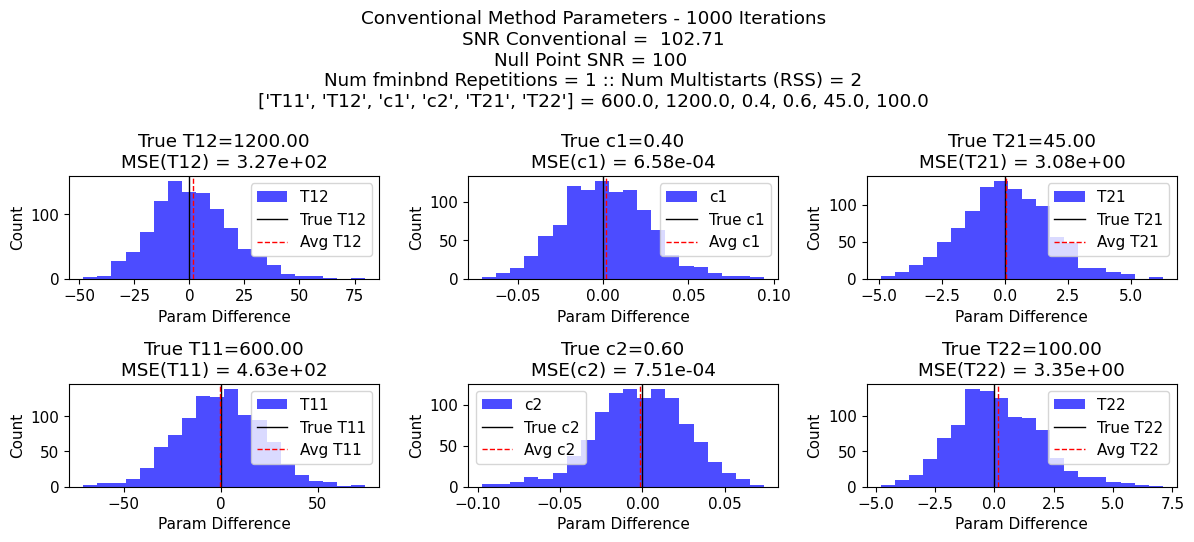

In [ ]:
##### Plots Conventional Results
title_hold = f"Conventional Method Parameters - {MC_iterations} Iterations\nSNR Conventional = {SNR_conventional : 0.2f}"
plt.rc('font', size = 11)
parameter_histogram(all_conven_params, true_params, param_list, title_hold)

In [ ]:
lb_default = [0,0,0,0,0,0]
ub_default = [T1_bound, T1_bound, 1, 1, T2_bound, T2_bound]

SNR_conventional = SNR_fixed
all_conven_params = np.zeros((MC_iterations, 6))

for iter in trange(MC_iterations):
    # np.random.seed(iter)
    mTE_c, mTI_c = np.meshgrid(TE_array, TI_array_conven)
    mS_c = S_biX_6p(mTE_c,mTI_c,*true_params)
    mS_noised_c = add_noise(mS_c, SNR_conventional)

    vecT_c = np.vstack((mTE_c.ravel(), mTI_c.ravel())) #flattens the data points
    vecS_c = mS_noised_c.ravel()

    #### Estimate parameters without any parameters known
    popt_6p_conven, RSS_hold = multistart_estimate_NLLS(S_biX_6p_ravel, vecT_c, vecS_c, lb_default, ub_default)
    all_conven_params[iter, :] = popt_6p_conven

100%|██████████| 1000/1000 [00:25<00:00, 39.70it/s]


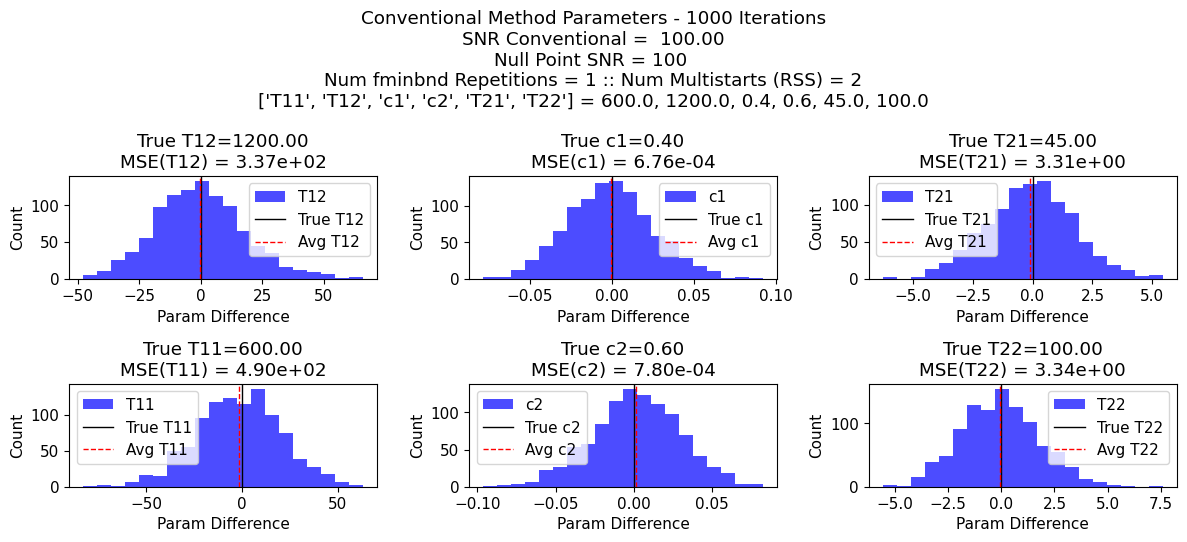

In [ ]:
##### Plots Conventional Results
title_hold = f"Conventional Method Parameters - {MC_iterations} Iterations\nSNR Conventional = {SNR_conventional : 0.2f}"
plt.rc('font', size = 11)
parameter_histogram(all_conven_params, true_params, param_list, title_hold)